<a href="https://colab.research.google.com/github/FHnt97/About_myself/blob/master/WESAD_Debiasing_Classification_Algorithms_GENDER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Debiasing classification algorithms for Occupational Stress Detection


---


## Content:
Find an introduction to the aim and dataset in the README file.

## BASE CODE

### Libraries

In [ ]:
# importing general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import Markdown, display

# libraries for data processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
! pip install fairlearn
! pip install aif360

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 5.1 MB/s 
     |████████████████████████████████| 569 kB 63.7 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=34da128c3047337402f19ab8dd442c4d72893fc060455aafe1da2e208318e66a
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


### Data load and wrangling

In [ ]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# open csv historical data
# if using collab use -->
path = '/content/drive/MyDrive/00 - thesis/Thesis - Fabia Höhne/Datasets/WESAD/m14_merged.csv'

# if using the GitHub repo use -->
# path = './Datasets/WESAD/m14_merged.csv'

df = pd.read_csv(path, sep=',', index_col=0)

In [ ]:
# reorder df columns & remove features which will not be used (lifestyle features, 3D data)
# remove min, max values, as mean & st. dev are already calculated
# remove according to corr analysis --> total of 18 attributes left 

cols = ['subject', 'label', 
        'age','gender_ female',
        'height', 'weight', 
        'BVP_std', 
        'EDA_mean', 'EDA_std', 
        'EDA_phasic_mean','EDA_phasic_std', 
        'EDA_smna_mean','EDA_smna_std', 
        'EDA_tonic_mean','EDA_tonic_std',  
        'Resp_std', 
        'TEMP_mean', 'TEMP_slope']

df = df[cols]


In [ ]:
# rename gender (male:0, female:1)
df = df.rename(columns = {'gender_ female':'gender'})

In [ ]:
# remove amusement state 
# 1: baseline, 2: stressed
df = df.loc[~(df['label'] == 0)]

In [ ]:
# chang 1,2 classification to 0,1 classification to avoid problems down the line
# 0: baseline, 1: stressed
df['label'] = df['label'].replace({1: 0})
df['label'] = df['label'].replace({2: 1})

In [ ]:
# bin age into groups to make binary (0: under 27)
df['age'] = np.where(df['age']>=28, '1', '0')

## Stress Model
-----


 [Stweard et al. (2020)](https://arxiv.org/pdf/2002.04176.pdf) use the following models to obtain a best- possible generic model for this dataset to detect stress:

- svm (gamma 0.0526) 
- log regression (11 penalization, c=1)
- k-nn (n=20)


#### libraries and helper functions

In [ ]:
# libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# libraries for data processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# libraries for metrics of models
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    roc_curve, auc, roc_auc_score,
    plot_confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    PrecisionRecallDisplay)

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

# libraries for fairness
from fairlearn.metrics import MetricFrame
from fairlearn.postprocessing import ThresholdOptimizer


from fairlearn.metrics import (
    MetricFrame,
    selection_rate, 
    demographic_parity_difference, 
    demographic_parity_ratio,
    false_positive_rate, 
    false_negative_rate,
    false_positive_rate_difference, 
    false_negative_rate_difference, 
    true_positive_rate, 
    true_negative_rate,
    selection_rate,
    count,
    equalized_odds_difference)

In [ ]:
# Helper functions metrics
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Equalized_odds_difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        " ------": (lambda x: "", True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

def metric_frame (feature):
    mf = MetricFrame({
        'FPR': false_positive_rate,
        'FNR': false_negative_rate,
        'TPR': true_positive_rate,
        'TNR': true_negative_rate, },
        y_test, test_preds, sensitive_features = feature)
    return mf.by_group


def summary_as_df(name, summary):
    a = summary.by_group
    a['overall'] = summary.overall
    return pd.DataFrame({name: a})

### Models set-up: test/train split

In [ ]:
# simple model - aware (inlc. proxies)
# set test & train data & defining age as sensitive attribute

# unaware: X = df.drop(columns=['gender', 'age', 'label', 'height', 'weight'])

X = df.drop(columns=['label'])
y = df['label']

A = df[['age', 'gender']]
Gender_str = A['gender'].map({ 1:"female", 0:"male"})

# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test, Gender_str_train, Gender_str_test = train_test_split(
    X, 
    y, 
    A, 
    Gender_str,
    test_size = 0.33, 
    random_state=42)

### Model set-up & definition

In [ ]:
# set up model:
classifiers = [LogisticRegression(C=1),
               SVC(kernel='rbf', gamma = 0.0526, probability = True),
               KNeighborsClassifier(n_neighbors=20),]


### Model fairness evaluation - Gender



##### Metric Frames

In [ ]:
# define sensitive attributes
gender = A_test['gender']

for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1
  
  print(f'Gender:{chr(10)}{model}: {chr(10)} {metric_frame (gender)} {chr(10)}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Ple

Age:
LogisticRegression(C=1): 
           FPR       FNR       TPR       TNR
age                                        
0       0.125  0.044118  0.955882     0.875
1    0.106383   0.27907   0.72093  0.893617 

Gender:
LogisticRegression(C=1): 
              FPR       FNR       TPR       TNR
gender                                        
0       0.078652  0.012987  0.987013  0.921348
1       0.305556  0.411765  0.588235  0.694444 

Age:
SVC(gamma=0.0526, probability=True): 
           FPR       FNR       TPR       TNR
age                                        
0    0.108333  0.191176  0.808824  0.891667
1    0.244681  0.093023  0.906977  0.755319 

Gender:
SVC(gamma=0.0526, probability=True): 
              FPR       FNR       TPR       TNR
gender                                        
0       0.174157  0.090909  0.909091  0.825843
1       0.138889  0.294118  0.705882  0.861111 

Age:
KNeighborsClassifier(n_neighbors=20): 
           FPR       FNR       TPR       TNR
age              

/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarn

##### Fairness metrics by group (equalized odds, demographic parity difference & ratio, false negative rate difference)

In [ ]:
# Metrics 
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"Unmitigated": (test_preds, y_pred)}

  print(f'Gender:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, gender)} {chr(10)}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Age:
LogisticRegression(C=1): 
                                Unmitigated
Equalized_odds_difference         0.234952
False negative rate difference    0.234952
Balanced error rate difference    0.108168
 ------                                   
Demographic parity difference     0.126262
  ------                                  
Overall AUC                       0.951419
AUC difference                    0.016475 

Age:
SVC(gamma=0.0526, probability=True): 
                                Unmitigated
Equalized_odds_difference         0.136348
False negative rate difference    0.098153
Balanced error rate difference    0.019097
 ------                                   
Demographic parity difference     0.090853
  ------                                  
Overall AUC                       0.919761
AUC difference                    0.023866 

Age:
KNeighborsClassifier(n_neighbors=20): 
                                Unmitigated
Equalized_odds_difference         0.201064
False negative 

##### visualisation help

In [ ]:
# demographic disparity
# https://github.com/fairlearn/fairlearn/blob/main/notebooks/Mitigating%20Disparities%20in%20Ranking%20from%20Binary%20Data.ipynb

from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy.stats import cumfreq

def compare_cdfs(data, A, num_bins=100):
    cdfs = {}
    assert len(np.unique(A)) == 2 
    
    limits = ( min(data), max(data) )
    s = 0.5 * (limits[1] - limits[0]) / (num_bins - 1)
    limits = ( limits[0]-s, limits[1] + s)
    
    for a in np.unique(A):
        subset = data[A==a]
        
        cdfs[a] = cumfreq(subset, numbins=num_bins, defaultreallimits=limits)
        
    lower_limits = [v.lowerlimit for _, v in cdfs.items()]
    bin_sizes = [v.binsize for _,v in cdfs.items()]
    actual_num_bins = [v.cumcount.size for _,v in cdfs.items()]
    
    assert len(np.unique(lower_limits)) == 1
    assert len(np.unique(bin_sizes)) == 1
    assert np.all([num_bins==v.cumcount.size for _,v in cdfs.items()])
    
    xs = lower_limits[0] + np.linspace(0, bin_sizes[0]*num_bins, num_bins)
    
    disparities = np.zeros(num_bins)
    for i in range(num_bins):
        cdf_values = np.clip([v.cumcount[i]/len(data[A==k]) for k,v in cdfs.items()],0,1)
        disparities[i] = max(cdf_values)-min(cdf_values)  
    
    return xs, cdfs, disparities
    
    
def plot_and_compare_cdfs(data, A, num_bins=100, loc='best'):
    xs, cdfs, disparities = compare_cdfs(data, A, num_bins)
    
    for k, v in cdfs.items():
        plt.plot(xs, v.cumcount/len(data[A==k]), label=k)
    
    assert disparities.argmax().size == 1
    d_idx = disparities.argmax()
    
    xs_line = [xs[d_idx],xs[d_idx]]
    counts = [v.cumcount[d_idx]/len(data[A==k]) for k, v in cdfs.items()]
    ys_line = [min(counts), max(counts)]
    
    plt.plot(xs_line, ys_line, 'o--')
    disparity_label = "max disparity = {0:.3f}\nat {1:0.3f}".format(disparities[d_idx], xs[d_idx])
    plt.text(xs[d_idx], 1, disparity_label, ha="right", va="top")
    
    plt.ylabel("cumulative frequency")
    plt.legend(loc=loc)
    plt.show()

#### visualisation

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


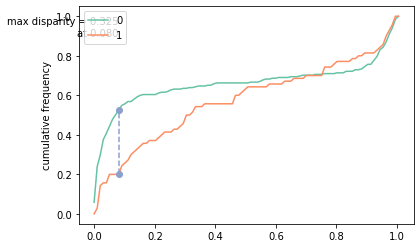

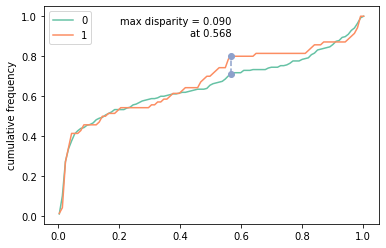

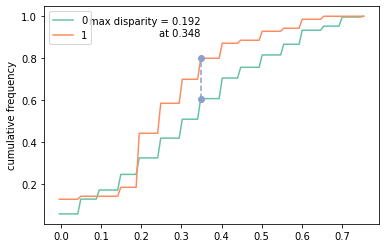

In [ ]:
%matplotlib inline

for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1


  display(HTML('<span id="disparity_unmitigated">'))
  plot_and_compare_cdfs(y_pred, gender)
  display(HTML('</span>'))

# Debiasing the model

---




Are we minitating bias (removing the problematic signal) - OR adding inclusion (add singal for deasired features for a re-weighted singal improved fairness?


Bias can come from the acutal data or the algorithm (this includes technical bias from data processing & amplified bias from the feedback loops)



pre-processing: suprression, class relabeling, reweighing, data transportation, database reparis, data augmentation


#### libraries and functions

In [ ]:
import aif360

from aif360.datasets import StandardDataset
from sklearn.pipeline import make_pipeline 
from sklearn.pipeline import Pipeline

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import DatasetMetric

from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.inprocessing import PrejudiceRemover

# fairlearn libraries
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation

from fairlearn.reductions import (ExponentiatedGradient, 
                                  EqualizedOdds, 
                                  ErrorRateParity)

In [ ]:
metrics = {
    'accuracy': accuracy_score,
    'false positive rate': false_positive_rate,
    'false negative rate': false_negative_rate,
    'selection rate': selection_rate,
    'count': count,
    'balanced error rate': balanced_accuracy_score}

#### 1. Reweigh samples (AIF360)

Based on:
1. [Correcting Unfair Binary Classification
Models](http://arno.uvt.nl/show.cgi?fid=157880)

2. [AIF360 example](https://nbviewer.org/github/IBM/AIF360/blob/master/examples/tutorial_credit_scoring.ipynb)


In [ ]:
# works only for SVM & log reg (knn doesnt do sample weights)
# set dataset in aif360 format
ds_aif = aif360.datasets.StandardDataset (df, 
                                         label_name="label",
                                         favorable_classes = [1], 
                                         protected_attribute_names=['gender'], 
                                         privileged_classes= [lambda x: x == 0],
                                         features_to_drop=['subject'])

In [ ]:
# test, train split
ds_train, ds_test = ds_aif.split([0.67], shuffle=True)

In [ ]:
# pre-processing - reweighing 
# define priviledged & unpriviledged groups
unpriv = [{'gender': 1}]
priv = [{'gender': 0}]


# reweigh
RW = Reweighing (unprivileged_groups = unpriv, 
                 privileged_groups = priv)

RW_train = RW.fit_transform(ds_train)

In [ ]:
# check for metric before and after transforming 
# OG ds
metric_train = BinaryLabelDatasetMetric(ds_train,
                                        unprivileged_groups = unpriv,
                                        privileged_groups = priv)

explainer_train = MetricTextExplainer(metric_train)

# transpormed ds
metric_transf_train = BinaryLabelDatasetMetric(RW_train,
                                               unprivileged_groups=unpriv,
                                               privileged_groups=priv)

explainer_transf_train = MetricTextExplainer(metric_transf_train)

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.004387


#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


#### Disparate impact

Before reweighing Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0122451124658398
After reweighing Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0000000000000004


In [ ]:
# refit rfc model & get metrics
X_train = RW_train.features
y_train = RW_train.labels.ravel()
w_train = RW_train.instance_weights

X_test = ds_test.features
y_test = ds_test.labels.ravel()

###### evaluations

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


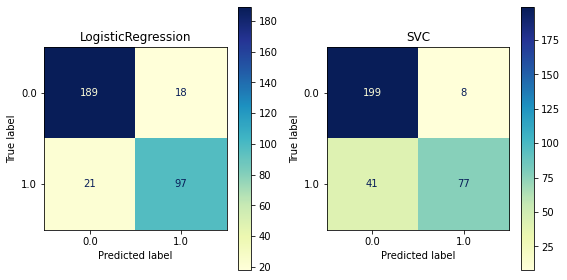

In [ ]:
# test models with reweighted data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

for cls, ax in zip(classifiers, axes.flatten()):
    dataset = RW_train
    cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
    
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)

plt.tight_layout()
plt.show()

In [ ]:
for cls in classifiers:
  cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = w_train)
  y_pred = cls.predict(X_test)
  
  print(f'{cls}: {chr(10)} {classification_report(y_test, y_pred)}')

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=1): 
               precision    recall  f1-score   support

         0.0       0.90      0.91      0.91       207
         1.0       0.84      0.82      0.83       118

    accuracy                           0.88       325
   macro avg       0.87      0.87      0.87       325
weighted avg       0.88      0.88      0.88       325

SVC(gamma=0.0526, probability=True): 
               precision    recall  f1-score   support

         0.0       0.83      0.96      0.89       207
         1.0       0.91      0.65      0.76       118

    accuracy                           0.85       325
   macro avg       0.87      0.81      0.82       325
weighted avg       0.86      0.85      0.84       325



TypeError: ignored

###### fairness evaluations

In [ ]:
# define test 
ds_test_pred = ds_test.copy(deepcopy=True)

In [ ]:
for cls in classifiers:
  dataset = RW_train
  cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
  y_pred = cls.predict(X_test)
  
  # scores on test set
  ds_test_pred.scores = cls.predict_proba(X_test)[:1]

  # predictions (0 or 1) on test set
  y_train_pred = cls.predict(X_train)
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

  print(f'Gender:{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, gender)} {chr(10)}')
  print(f'Gender:{chr(10)}{cls}: {chr(10)} {metric_frame (gender)} {chr(10)}') 


  mf1 = MetricFrame(metrics=metrics,
                    y_true=y_test,
                    y_pred=y_pred,
                    sensitive_features=gender)

# The disaggregated metrics are stored in a pandas Series mf1.by_group:
  print(f"{cls}:\n {mf1.by_group}\n")
  print(f"{cls} difference:\n {mf1.difference(method='between_groups')}\n")

Gender:
LogisticRegression(C=1): 
                                mitigated_pre-processing
Equalized_odds_difference                      0.044598
False negative rate difference                 0.020833
Balanced error rate difference                 0.032716
 ------                                                
Demographic parity difference                  0.019219
  ------                                               
Overall AUC                                    0.867539
AUC difference                                 0.032716 

Gender:
LogisticRegression(C=1): 
           FPR       FNR       TPR       TNR
age                                        
0    0.104839    0.1875    0.8125  0.895161
1    0.060241  0.166667  0.833333  0.939759 



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.


NameError: ignored

#### Fair learn - post processign methods -- wrappers



In [ ]:
# set test & train data & defining age as sensitive attribute - UNAWARE

X = df.drop(columns=['gender', 'age', 'label', 'height', 'weight'])
y = df['label']

A = df[['gender']]

# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test, Gender_str_train, Gender_str_test = train_test_split(
    X, 
    y, 
    A, 
    Gender_str,
    test_size = 0.33, 
    random_state=42)


#### 3. ExponentiatedGradient - reduction (fair learn)

In [ ]:
for cls in classifiers:
  expgrad_est = ExponentiatedGradient(estimator=cls,
                                    constraints=ErrorRateParity(difference_bound=0.01)) 
  
  expgrad_est.fit(X_train, y_train, sensitive_features=A_train)
  
  y_pred_reductions = expgrad_est.predict(X_test, random_state=42)
  
  mf_eg =  MetricFrame(metrics=metrics,
                                       y_true=y_test,
                                       y_pred=y_pred_reductions,
                                       sensitive_features=A_test
                                       ) # gender<>age
  df_results = pd.concat([mf_eg.by_group],
                          keys=['ExponentiatedGradient'],
                          axis=1)
  
  print (f'{cls}:{chr(10)} {df_results}{chr(10)}')
  print(f"{cls} difference:\n {mf_eg.difference(method='between_groups')}\n")


  # visualize mitigated
  mf_eg.by_group.plot(
      kind="bar",
  #    ylim=[0, 1],
      subplots=True,
      layout=[3, 3],
      legend=False,
      figsize=[12, 8],
      title=f'Show all metrics WESAD - exponentiated gradiant - {cls}',
  )



  y_train_pred = cls.predict(X_train)
  test_preds = (y_pred_reductions >= np.mean(y_train)) * 1

  models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

  print(f':{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, A_test)} {chr(10)}') 

#### 4. Thresholdoptimizer (fair learn - post processing)

ThresholdOptimizer takes in an exisiting (possibly pre-fit) machine learning model whose predictions act as a scoring function and identifies a separate thrceshold for each group in order to optimize some specified objective metric (such as balanced accuracy) subject to specified fairness constraints (such as false negative rate parity). Thus, the resulting classifier is just a suitably thresholded version of the underlying machinelearning model.

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=1):
     ThresholdOptimizer                                                         \
              accuracy false positive rate false negative rate selection rate   
age                                                                             
0             0.898936            0.083333            0.132353       0.367021   
1             0.846715             0.06383            0.348837       0.248175   

                               
    count balanced error rate  
age                            
0     188            0.892157  
1     137            0.793667  

LogisticRegression(C=1) difference:
 accuracy               0.052221
false positive rate    0.019504
false negative rate    0.216484
selection rate         0.118846
count                        51
balanced error rate     0.09849
dtype: object

:
LogisticRegression(C=1): 
                                mitigated_pre-processing
Equalized_odds_difference                      0.216484
False negative rate di

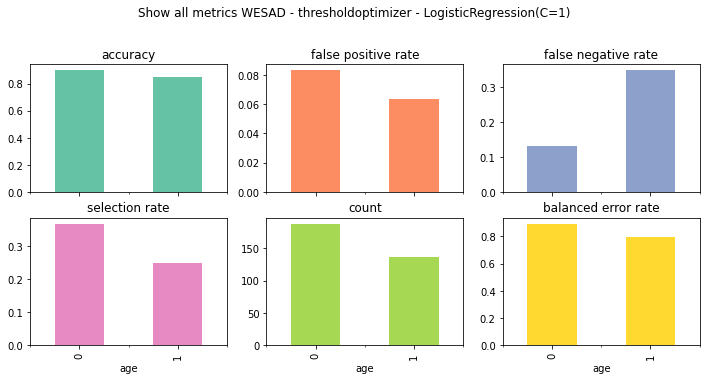

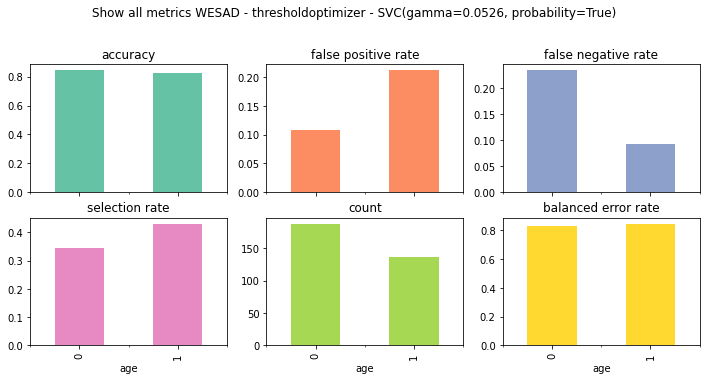

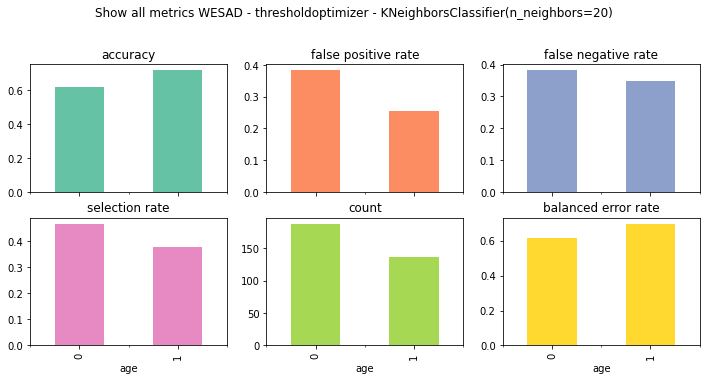

In [ ]:
for cls in classifiers:
    unmitigated_pipeline = Pipeline(steps=[("model", cls)])

    unmitigated_pipeline.fit(X_train, y_train)
    
    postprocess_est = ThresholdOptimizer(estimator=unmitigated_pipeline,
                                        constraints="equalized_odds",
                                        objective="balanced_accuracy_score",
                                        prefit=True,
                                        predict_method='predict_proba')
    
    postprocess_est.fit(X_train, y_train, sensitive_features=A_train) # change a test in train/ test sample

    y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test) # gender<>age

    mf_to = MetricFrame(metrics=metrics,
                                          y_true=y_test,
                                          y_pred=y_pred_postprocess,
                                          sensitive_features=A_test) # gender<>age
    
    df_results = pd.concat([mf_to.by_group],
                            keys=['ThresholdOptimizer'],
                            axis=1)

    print (f'{cls}:{chr(10)} {df_results}{chr(10)}')

    print(f"{cls} difference:\n {mf_to.difference(method='between_groups')}\n")
    
    y_train_pred = cls.predict(X_train)
    test_preds = (y_pred_postprocess >= np.mean(y_train)) * 1

    models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

    print(f':{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, A_test)} {chr(10)}') # change age<> gender

    # visualize mitigated
    mf_to.by_group.plot(
        kind="bar",
    #    ylim=[0, 1],
        subplots=True,
        layout=[3, 3],
        legend=False,
        figsize=[12, 8],
        title=f'Show all metrics WESAD - thresholdoptimizer - {cls}',
    )


  